In [1]:
import pylib as pl
from pylib import read_schism_hgrid, read_schism_bpfile
from pylib import zdata, loadz, savez, ReadNC, WriteNC

import numpy as np
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

In [2]:
#------------------------------------------------------------------------------
#input
#------------------------------------------------------------------------------
grd=r'C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\vgrid\hgrid.gr3'        #hgrid name (grid.npz, or hgrid.gr3)
bname=r'C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\vgrid\transect.bp'   #transect bpfile

hsm=np.array([1,5,10,30,50,70,100,200,310]) #depths
nhm=len(hsm)
nv=np.array([2,4,6,8,11,14,17,20,20]) # number of layers per hsm, note 2 layers = top  and bottom, i.e. 2D

In [4]:
#------------------------------------------------------------------------------
#compute master grid
#------------------------------------------------------------------------------
nvrt=nv[-1]; z_mas=np.ones([nhm,nvrt])*np.nan; eta=0.0
for m, [hsmi,nvi] in enumerate(zip(hsm,nv)):
    #strethcing funciton
    theta_b=0; theta_f=2.5; hc=10.5
    hc=min(hsmi,hc)

    for k in np.arange(nvi):
        sigma= k/(1-nvi)  #zi=-sigma #original sigma coordiante

        #compute zcoordinate
        cs=(1-theta_b)*np.sinh(theta_f*sigma)/np.sinh(theta_f)+theta_b*(np.tanh(theta_f*(sigma+0.5))-np.tanh(theta_f*0.5))/2/np.tanh(theta_f*0.5)
        z_mas[m,k]=eta*(1+sigma)+hc*sigma+(hsmi-hc)*cs

    #normalize z_mas
    z_mas[m]=-(z_mas[m]-z_mas[m,0])*hsmi/(z_mas[m,nvi-1]-z_mas[m,0])
s_mas=np.array([z_mas[i]/hsm[i] for i in np.arange(nhm)])

check: master grid layer=4, hsm=50, nv=11
check: master grid layer=5, hsm=70, nv=14
check: master grid layer=6, hsm=100, nv=17


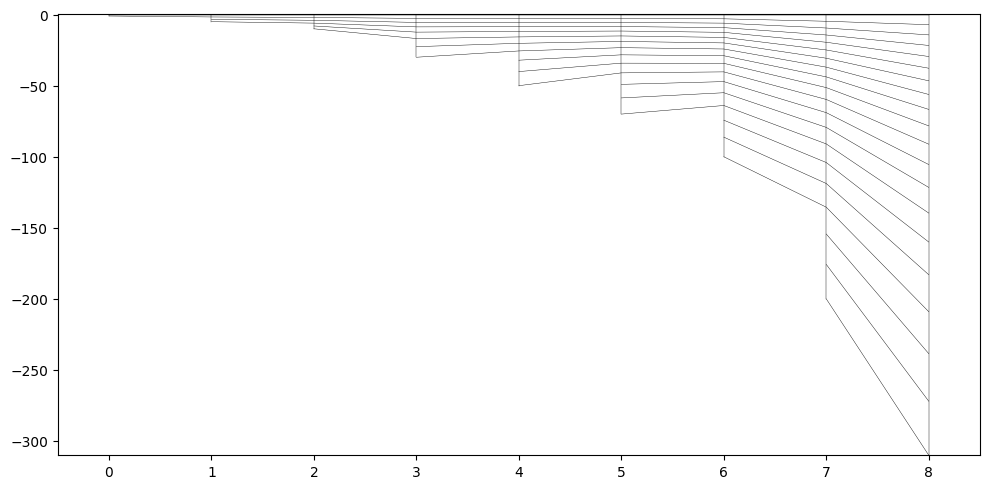

In [5]:
#check master grid
for i in np.arange(nhm-1):
    if min(z_mas[i,:nv[i]]-z_mas[i+1,:nv[i]])<0: print('check: master grid layer={}, hsm={}, nv={}'.format(i+1,hsm[i+1],nv[i+1]))

#plot master grid
figure(figsize=[10,5])
for i in np.arange(nhm): plot(i*np.ones(nvrt),z_mas[i],'k-',lw=0.3)
for k in np.arange(nvrt): plot(np.arange(nhm),z_mas.T[k],'k-',lw=0.3)
setp(gca(),xlim=[-0.5,nhm-0.5],ylim=[-hsm[-1],0.5])
gcf().tight_layout()
#pl.move_figure(gcf(),0,0)
savefig('Master_Grid',dpi=200)

### Begin of what was changed from the original script

In [6]:
#------------------------------------------------------------------------------
#compute vgrid
#------------------------------------------------------------------------------
#read hgrid
gd=loadz(grd).hgrid if grd.endswith('.npz') else read_schism_hgrid(grd)
fpz=gd.dp<hsm[0]; gd.dp[fpz]=hsm[0]

#find hsm index for all points
rat=np.ones(gd.np)*np.nan; nlayer=np.zeros(gd.np).astype('int');
ind1=np.zeros(gd.np).astype('int'); ind2=np.zeros(gd.np).astype('int')
for m, hsmi in enumerate(hsm):
    if m==0:
        fp=gd.dp<=hsm[m];
        ind1[fp]=0; ind2[fp]=0; rat[fp]=0; nlayer[fp]=nv[0]
    else:
        fp=(gd.dp>hsm[m-1])*(gd.dp<=hsm[m])
        ind1[fp]=m-1; ind2[fp]=m
        rat[fp]=(gd.dp[fp]-hsm[m-1])/(hsm[m]-hsm[m-1]); nlayer[fp]=nv[m]
        
#Find the last non NaN node and fills the NaN values with it
last_non_nan = (~np.isnan(z_mas)).cumsum(1).argmax(1)
z_mas=np.array([np.nan_to_num(z_mas_arr,nan=z_mas_arr[last_non_nan[i]]) for i, z_mas_arr in enumerate(z_mas)])
znd=z_mas[ind1]*(1-rat[:,None])+z_mas[ind2]*rat[:,None]; #z coordinate
for i in np.arange(gd.np): 
    1+1
    znd[i,nlayer[i]-1]=-gd.dp[i]
    znd[i,nlayer[i]:]=np.nan
snd=znd/gd.dp[:,None]; #sigma coordinate

In [7]:
#check vgrid
for i in np.arange(gd.np):
    for k in np.arange(nvrt-1):
        if znd[i,k]<=znd[i,k+1]:
            sys.exit('wrong vertical layers')

In [8]:
#write vgrid.in
fid=open('vgrid.in','w+')
fid.write('           1 !average # of layers={:0.2f}\n          {} !nvrt\n'.format(np.mean(nlayer),nvrt))
bli=[]#bottom level index
for i in np.arange(gd.np):
    nlayeri=nlayer[i]; si=np.flipud(snd[i,:nlayeri])   
    bli.append(nvrt-nlayeri+1)
    fstr=f"         {nvrt-nlayeri+1:2}"
    fid.write(fstr)
for i in range(nvrt):
    fid.write(f'\n         {i+1}')
    for n,bl in enumerate(bli):
        si=np.flipud(snd[n])
        if bl <= i+1:
            fid.write(f"      {si[i]:.6f}")
        else:
            fid.write(f"      {-9.:.6f}")

fid.close()
print('Average number of layers is: {:0.2f}'.format(np.mean(nlayer)))

Average number of layers is: 6.17


### End of what was changed from the original script

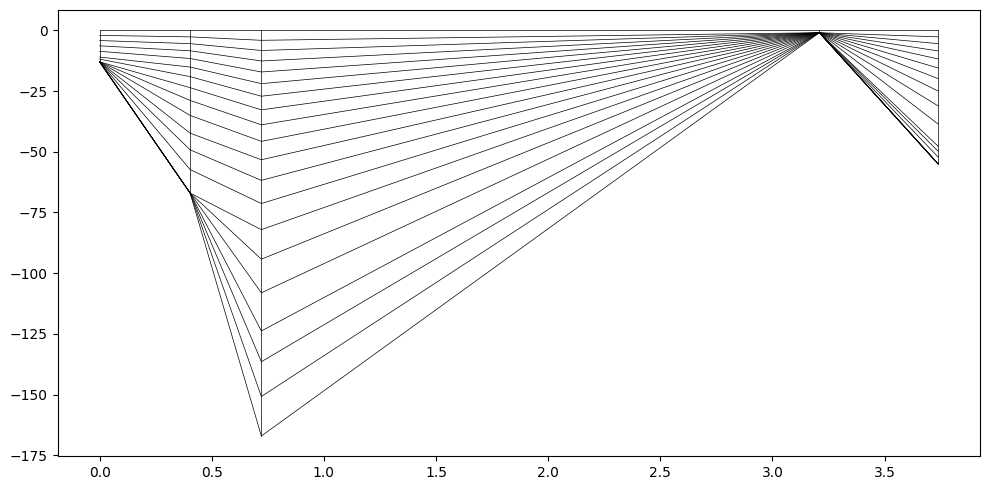

In [9]:
#------------------------------------------------------------------------------
#plot transect
#------------------------------------------------------------------------------
if os.path.exists(str(bname)):
    bp=read_schism_bpfile(str(bname))

    #compute dist
    dist=[0,]
    for i in np.arange(bp.nsta-1):
        disti=abs((bp.x[i+1]-bp.x[i])+1j*(bp.y[i+1]-bp.y[i]))+dist[i]
        dist.append(disti)
    dist=np.array(dist)

    #compute zcor
    sindp=pl.near_pts(pl.c_[bp.x,bp.y],pl.c_[gd.x,gd.y]); zi=znd[sindp]
    for i in np.arange(bp.nsta): fpn=np.isnan(zi[i]); zi[i][fpn]=min(zi[i])


    #plot
    figure(figsize=[10,5])
    for k in np.arange(nvrt): plot(dist,zi[:,k],'k',lw=0.5)
    for i in np.arange(bp.nsta): plot(np.ones(nvrt)*dist[i],zi[i],'k',lw=0.5)
    #setp(gca(),ylim=[zi.min()-1,0.5],xlim=[0,dist.max()])
    gcf().tight_layout()
    # move_figure(gcf(),0,0)